### Exercise 1-3. 

This exercise deals with some issues of ‘‘sensitivity’’ in the steel models.

(a) For the linear program of Figures 1-5a and 1-5b, display Time and Make.rc. What do these values tell you about the solution? (You may wish to review the explanation of marginal values and reduced costs in Section 1.6.)

(b) Explain why the reheat time constraints added in Figure 1-6a result in a higher production of plate and a lower production of bands.

(c) Use AMPL to verify the following statements: If the available reheat time is increased from 35 to 36 in the data of Figure 1-6b, then the profit goes up by $\$$1800 as predicted in Section 1.6. If the reheat time is further increased to 37, the profit goes up by another $\$$1800. However, if the reheat time is increased to 38, there is a smaller increase in the profit, and further increases past 38 have no effect on the optimal profit at all. To change the reheat time to, say, 26 without changing and reading the data file over again, type the command let avail["reheat"] := 36; By trying some other values of the reheat time, confirm that the profit increases by $\$$1800 per extra hour for any number of hours between 35 and 37 9/14, but that any increase in the reheat time beyond 37 9/14 hours doesn’t give any further profit. Draw a plot of the profit versus the number of reheat hours available, for hours ≥ 35.

(d) To find the slope of the plot from (c) — profit versus reheat time available — at any particular reheat time value, you need only look at the marginal value of Time["reheat"]. Using this observation as an aid, extend your plot from (c) down to 25 hours of reheat time. Verify that the slope of the plot remains at $6000 per hour from 25 hours down to less than 12 hours of reheat time. Explain what happens when the available reheat time drops to 11 hours

In [120]:
import pandas as pd
from amplpy import AMPL, Environment

In [121]:
ampl = AMPL(Environment('/opt/ampl.linux64'))

In [122]:
ampl.reset()

In [123]:
ampl.read('./ex--1-3c.mod')

In [124]:
ampl.readData('./ex--1-3c.dat')

In [125]:
variables = ('bands','coils','plate')
time_constraints = ('reheat','roll')

In [126]:
def model_overview(ampl=None):
    print(ampl.getConstraint('Time'))
    #print(ampl.getConstraint('Time').get('reheat'))
    #print(ampl.getConstraint('Time').get('roll'))
    print()
    print('Variables and their bounds')
    for i in ampl.getVariables():
        [print(i[1].get(j)) for j in variables]
    print()
    print('Constraints and their limits')
    for i in ampl.getConstraints():
        #if time_constraints == (): 
        #    print(i[1].get())
        if i[0] == 'Time': [print(i[1].get(j)) for j in time_constraints]
        if i[0] == 'max_weight': print(i[1].get())
        if i[0] == 'min_tons': [print(i[1].get(j)) for j in variables]
    print()
    print('Objective Function')
    print(ampl.getObjective('Total_Profit').get())

model_overview(ampl=ampl)

subject to Time{s in Stage} : sum{p in Products} 1/tonsPerHour[p,s]*X[p]
   <= maxHours[s];

Variables and their bounds
var X['bands'] >=1000, <=6000;
var X['coils'] >=500, <=4000;
var X['plate'] >=750, <=3500;

Constraints and their limits
subject to Time['reheat']:
	0.005*X['bands'] + 0.005*X['coils'] + 0.005*X['plate'] <= 35;
subject to Time['roll']:
	0.005*X['bands'] + 0.00714286*X['coils'] + 0.00625*X['plate'] <= 40;

Objective Function
maximize Total_Profit:
	25*X['bands'] + 30*X['coils'] + 29*X['plate'];


In [127]:
ampl.eval('expand Total_Profit;')
ampl.eval('expand Time;')

maximize Total_Profit:
	25*X['bands'] + 30*X['coils'] + 29*X['plate'];

subject to Time['reheat']:
	0.005*X['bands'] + 0.005*X['coils'] + 0.005*X['plate'] <= 35;

subject to Time['roll']:
	0.005*X['bands'] + 0.00714286*X['coils'] + 0.00625*X['plate'] <= 40;



In [128]:
for variable in variables:
    ampl.eval('expand X["{}"];'.format(variable))

Coefficients of X['bands']:
	Time['reheat']   0.005
	Time['roll']     0.005
	Total_Profit    25

Coefficients of X['coils']:
	Time['reheat']   0.005
	Time['roll']     0.00714286
	Total_Profit    30

Coefficients of X['plate']:
	Time['reheat']   0.005
	Time['roll']     0.00625
	Total_Profit    29



In [129]:
ampl.eval('display _nvars, _ncons;')

_nvars = 3
_ncons = 2



In [130]:
print(ampl.getOption('solver'))
ampl.setOption('solver','cplex')
print(ampl.getOption('solver'))

minos
cplex


In [131]:
ampl.solve()

CPLEX 12.8.0.0: optimal solution; objective 190071.4286
2 dual simplex iterations (0 in phase I)


In [132]:
print(ampl.getObjective('Total_Profit').get().value())

190071.42857142858


#### Shadow Price or Dual Price or Marginal Price

In [133]:
ampl.eval('display Total_Profit;')
for i in ampl.getConstraints():
    print(i[1].getValues())
#print(ampl.getConstraint('Time').getValues())

Total_Profit = 190071

   index0    |  Time.dual  
  'reheat'   | 1799.9999999999973
   'roll'    | 3200.0000000000018



### Decision Variable Solution and Reduced Cost

In [134]:
X_result = list()
for p in variables:
    X_result.append([
        p,
        ampl.getVariable('X').get(p).lb(), 
        ampl.getVariable('X').get(p).value(),
        ampl.getVariable('X').get(p).ub(),
        ampl.getVariable('X').get(p).rc()
    ])
df_X_result = pd.DataFrame(X_result)
df_X_result.rename(columns={0:'DecisionVariable_X',
                            1:'X_LowerBound',
                            2:'X_Solution',
                            3:'X_UpperBound',
                            4:'X_ReducedCosts'},
                   inplace=True)
df_X_result.set_index('DecisionVariable_X',inplace=True)
df_X_result

,X_LowerBound,X_Solution,X_UpperBound,X_ReducedCosts
DecisionVariable_X,,,,
bands,1000.0,3357.142857,6000.0,3.552714e-15
coils,500.0,500.000000,4000.0,-1.857143e+00
plate,750.0,3142.857143,3500.0,0.000000e+00


In [135]:
print(ampl.getData('X'))
values = ampl.getVariable('X').getValues()
print(values)
df = values.toPandas()
print(values.toList())
print(values.toDict())

   index0    |      X      
  'bands'    | 3357.1428571428542
  'coils'    |     500     
  'plate'    | 3142.8571428571458

   index0    |    X.val    
  'bands'    | 3357.1428571428542
  'coils'    |     500     
  'plate'    | 3142.8571428571458

[('bands', 3357.142857142854), ('coils', 500.0), ('plate', 3142.857142857146)]
{'bands': 3357.142857142854, 'coils': 500.0, 'plate': 3142.857142857146}


In [136]:
df['X.reheatRate'] = 1/200
df['X.rollRate'] = [1/i for i in (200,140,160)]
df['X.reheat']=df['X.val']*df['X.reheatRate']
df['X.roll']=df['X.val']*df['X.rollRate']
df['X.ratio']=df['X.val']/df['X.val'].sum()
df

,X.val,X.reheatRate,X.rollRate,X.reheat,X.roll,X.ratio
bands,3357.142857,0.005,0.005000,16.785714,16.785714,0.479592
coils,500.000000,0.005,0.007143,2.500000,3.571429,0.071429
plate,3142.857143,0.005,0.006250,15.714286,19.642857,0.448980


In [137]:
df_ = ampl.getEntity('dollarProfitPerTon').getValues().toPandas()
df_ = df.join(df_)
print('Reheat:{} Roll:{}'.format(df['X.reheat'].sum(),df['X.roll'].sum()))
print('Total Production = {} tons'.format(df['X.val'].sum()))
print('total profit under new objective function = {}'.format((df_.loc[:,'X.val'] * df_.loc[:,'dollarProfitPerTon']).sum()))

Reheat:35.0 Roll:40.0
Total Production = 7000.0 tons
total profit under new objective function = 190071.42857142858


In [138]:
df = pd.DataFrame(
    [[200,200,25],
     [200,140,30],
     [200,160,29]],
columns = ['tons/Hr.Reheat','tons/Hr.Roll','$/Hr'],
index = ['bands','coils','plate'])
df['$/tons.Reheat'] = (1/df['tons/Hr.Reheat'])*df['$/Hr']
df['$/tons.Roll'] = (1/df['tons/Hr.Roll'])*df['$/Hr']
df['$/tons'] = df['$/tons.Reheat'] + df['$/tons.Roll']
df

,tons/Hr.Reheat,tons/Hr.Roll,$/Hr,$/tons.Reheat,$/tons.Roll,$/tons
bands,200,200,25,0.125,0.125000,0.250000
coils,200,140,30,0.150,0.214286,0.364286
plate,200,160,29,0.145,0.181250,0.326250


In [143]:
import numpy as np
result = list()
for reheat_limit in np.arange(35,40,0.01):
    #print(reheat_limit)
    #ampl.eval('let maxHours["reheat"] := 49;') #alternate method to set constraint limit. 
    ampl.getParameter('maxHours').set('reheat',reheat_limit)
    #model_overview(ampl=ampl)
    ampl.setOption('solver_msg',False)
    #ampl.setOption('cplex_options','outlev=0')
    #ampl.solve() #alternate method to solve ampl model. This method will print solver output. 
    #this would annoyingly print CPLEX version each time we call ampl.solve()
    output_string = ampl.getOutput('solve;')  #output of solver is stored as string. 
    df1 = ampl.getConstraint('Time').getValues().toPandas()
    result.append([reheat_limit, 
                   ampl.getObjective('Total_Profit').get().value(),
                   df1.loc[df1.index=='reheat','Time.dual'][0],
                   df1.loc[df1.index=='roll','Time.dual'][0]
                 ])

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
df = pd.DataFrame(result,columns=['reheat_limit',
                                  'objective_func',
                                  'reheat_shadow_price',
                                  'roll_shadow_price'])
df

,reheat_limit,objective_func,reheat_shadow_price,roll_shadow_price
0,35.00,190071.428571,1800.0,3200.0
1,35.01,190089.428571,1800.0,3200.0
2,35.02,190107.428571,1800.0,3200.0
3,35.03,190125.428571,1800.0,3200.0
4,35.04,190143.428571,1800.0,3200.0
5,35.05,190161.428571,1800.0,3200.0
6,35.06,190179.428571,1800.0,3200.0
7,35.07,190197.428571,1800.0,3200.0
8,35.08,190215.428571,1800.0,3200.0
9,35.09,190233.428571,1800.0,3200.0


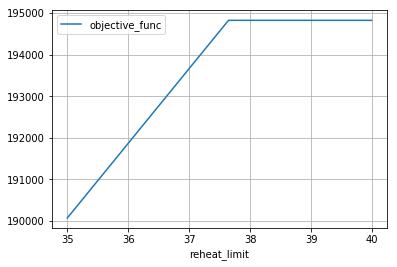

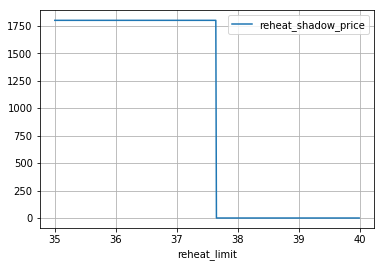

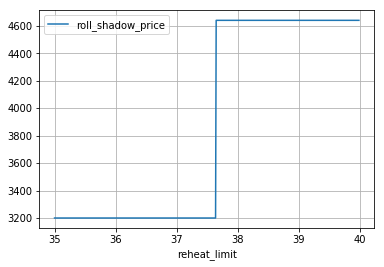

In [145]:
df.plot(x='reheat_limit',y='objective_func',grid=True)
df.plot(x='reheat_limit',y='reheat_shadow_price',grid=True)
df.plot(x='reheat_limit',y='roll_shadow_price',grid=True)

## Summary

(a) Interpretation of Shadow Price/Dual Price and Reduced Cost:

1. Shadow Price (Dual Price): The objective function has value of $\$$194828.57 and the Time constraint, has a shadow price of $\$$4640. This means that if we increased the time constraint limit of 40 hours by 1 hour to 41 hour, then the objective function (total profit) would increase from $\$$194828.57 to $\$$199468.57 ($\$$199468.57-$\$$194828.57 = $\$$4640.0)

2. Reduced Cost: Firstly reduced cost applies to decision variables. Reduced cost is non zero for decision variables that are solved at their min or max bounds. In this case bands are at max of 6000 tons and has a reduced cost of $\$$1.8 while coils are at min of 500 tons and has a reduced cost of $\$$-3.14. 

    * If max bound of bands was increased by 1 unit from 6000 tons to 6001, this would increase the objective function (total profit) from $\$$194828.57 to $\$$194830.37 ($\$$194830.37-$\$$194828.57=$\$$1.8=Reduced Cost of 699).
    * If min bound of coils was increased by 1 unit from 500 tons to 501, this would decrease the objective function (total profit) from $\$$194828.57142857142 to $\$$194825.42857142858 ($\$$194828.57142857142-$\$$194825.42857142858=$\$$3.142857142840512).
    
(b) Introducing the reheat time constraint, increased production of plate and decreased production of bands. 

* The reheat stage tons per hour for bands, coils and plate are same for all. Therefore if the max limit for reheat stage was also same as roll stage time constraint (i.e. 40 hours for both reheat and roll stage), then there would be no change in solution. 
     
* When adding the reheat stage time constraint, the change in solution was mainly because the reheat constraint limit was less than 40 hours. This makes plate more attractive because, the $/hr is higher for plate than bands. Its heighest for coils, however, in the roll stage, the ton per hour for coils is the worst.

(c) vary reheat constraint limit from 35 to 40. 

* we can see how objective function continues to increase from $\$$190071.428571 to $\$$194828.571429. See plots above.

* another observation is reheat constraint shadow price is flat at $\$$1800 and later drops 0; indicating that the reheat constraint is no more binding once the limit is increased to some value. 

* finally we also see that roll constraint shadow price is flat at $\$$3200 and later increases to $\$$4640; indicating that the roll constraint binds even more (has a stronger shadow price) once the reheat constraint becomes non-binding.